# Maren Equations

Sergey and Lauren developed a set of equtions found here:

Nuzhdin, S. V, Friesen, M. L., & McIntyre, L. M. (2012). Genotype-phenotype mapping in a post-GWAS world. Trends in Genetics : TIG, 28(9), 421–6. doi:10.1016/j.tig.2012.06.003

which potentially allow for the identificqtion of *cis*- and *trans*-effects. Here I try using these qeustions and test if they give reasonable results.

Basics:
For a given gene the expression level of $E_{ii}$ of allele *i* in F1 genotype *i*. 

$E_{ii} = \mu + C_i + (T_i + T_t)/2$

$E_{ti} = \mu + C_t + (T_i + T_t)/2$

For each allele the *cis*- and *trans*-effects are deviations from the population means, we expect that they will sum to zero:

$\sum^n_{i=1}C_i = 0$

$\sum^n_{i=1}T_i = 0$

Then the expected difference in expression between the Line and Tester allele over the entire population is:

$\sum^n_{i=1} \frac{E_{ti} - E_{ii}}{n}$

Which can be re-written as

$\sum^n_{i=1} \frac{C_{t} - C_{i}}{n} = C_t$

The *cis*-effect of allele *i* can be estimated by:

$\hat C_i = \hat E_{ii} - \hat E_{ti} + \hat C_t$

In [93]:
# Set-up default environment
%run '../ipython_startup.py'

# Import additional libraries
import sas7bdat as sas
import cPickle as pickle

from ase_cisEq import marenEq
from ase_cisEq import marenPrintTable

from ase_normalization import meanCenter
from ase_normalization import q3Norm
from ase_normalization import meanStd

Importing commonly used libraries: os, sys, numpy as np, scipy as sp, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt, mclib_Python/flagging as fg
Creating project level variables: MCLAB = /home/jfear/mclab, PROJ = /home/jfear/mclab/cegs_ase_paper, TODAY = 20150909
Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
def denPlt(df, values='cis_line', columns='line', index='fusion_id', layout=(7, 7)):
    axes = df.pivot_table(values=values, columns=columns, index=index).plot(kind='kde', subplots=True, layout=layout, figsize=(10,10), rot=90, xlim=(-800, 800))

    for ax in axes.ravel():
        ax.get_yaxis().set_visible(False)
        h, lbl = ax.get_legend_handles_labels()
        ax.set_title(lbl[0])
        ax.get_legend().remove()

    plt.tight_layout()
    return plt.gcf()

In [95]:
def scatPlt(df, line='sum_line', tester='sum_tester', title=None):
    # Plot the cis-line effects x proportion by fusion
    df['prop'] = df[tester] / (df[line] + df[tester])
    # Create 5x5 panel plot
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.suptitle(title)
    axes = axes.ravel()

    # Group by fusion_id
    grp = df.groupby('fusion_id')
    for i, (n, gdf) in enumerate(grp):
        gdf.plot(kind='scatter', x='cis_line', y='prop', ax=axes[i], title=n)
        if i == 24:
            break
    
    return fig

## Import clean data set

This data set was created by: ase_summarize_ase_filters.sas

The data has had the following droped:
* regions that were always bias in 100 genome simulation
* regions with APN $\le 25$
* regions not in at least 10% of genotypes
* regions not in mated and virgin
* genotypes with extreme bias in median(q5_mean_theta)
* genotypes with $\le500$ regions

In [96]:
# Import clean dataset
with sas.SAS7BDAT(os.path.join(PROJ, 'sas_data/clean_ase_stack.sas7bdat')) as FH:
    df = FH.to_data_frame()
    
dfClean = df[['line', 'mating_status', 'fusion_id', 'flag_AI_combined', 'q5_mean_theta', 'sum_both', 'sum_line', 'sum_tester', 'sum_total', 'mean_apn']]

[clean_ase_stack.sas7bdat] header length 65536 != 8192
[clean_ase_stack.sas7bdat] [clean_ase_stack.sas7bdat] header length 65536 != 8192


### Additional cleaning
For the maren equations, I am also going to drop exonic regions with less than 10 genotypes. The maren equations make some assumptions about the population level sums. Obvisouly the more genotypes that are present for each fusions the better, but I am comfortable with as few as 10 genotypes.

In [97]:
# Drop groups with less than 10 lines per fusion
grp = dfClean.groupby(['mating_status', 'fusion_id'])
dfGt10 = grp.filter(lambda x: x['line'].count() >= 10).copy()
print 'Rows ' + str(dfGt10.shape[0])
print 'Columns ' + str(dfGt10.shape[1])

Rows 131700
Columns 10


## Raw Counts

Raw counts seem to have some issues. The magnitude of line *cis* and tester *trans* effects are very different, while tester *cis* and *trans* are the same number just different signs. Also of concern is that the estimated cis and trans effects for the line are not centered at 0, which is a major assumption of the equations.

In [98]:
# Calculate Maren TIG equations by mating status and exonic region
marenRawCounts = marenEq(dfGt10, Eii='sum_line', Eti='sum_tester', group=['mating_status', 'fusion_id'])
marenRawCounts['mag_cis'] = abs(marenRawCounts['cis_line'])
marenPrintTable(marenRawCounts)

,,,flag_AI_combined,sum_both,sum_line,sum_tester,cis_line,cis_tester,mean_apn
line,mating_status,fusion_id,,,,,,,
r101,M,F10005_SI,0,1274,155,133,28.666667,6.666667,29.523922
r280,M,F10005_SI,0,1208,126,143,-10.333333,6.666667,27.917307
r315,M,F10005_SI,0,1231,237,218,25.666667,6.666667,31.867690
r324,M,F10005_SI,1,2554,349,276,79.666667,6.666667,60.087419
r335,M,F10005_SI,0,1339,215,217,4.666667,6.666667,33.474306
r340,M,F10005_SI,1,1897,332,102,236.666667,6.666667,44.059067
r357,M,F10005_SI,1,2797,358,408,-43.333333,6.666667,67.345540
r358,M,F10005_SI,0,1494,185,162,29.666667,6.666667,34.797401
r365,M,F10005_SI,0,2313,385,386,5.666667,6.666667,58.291790


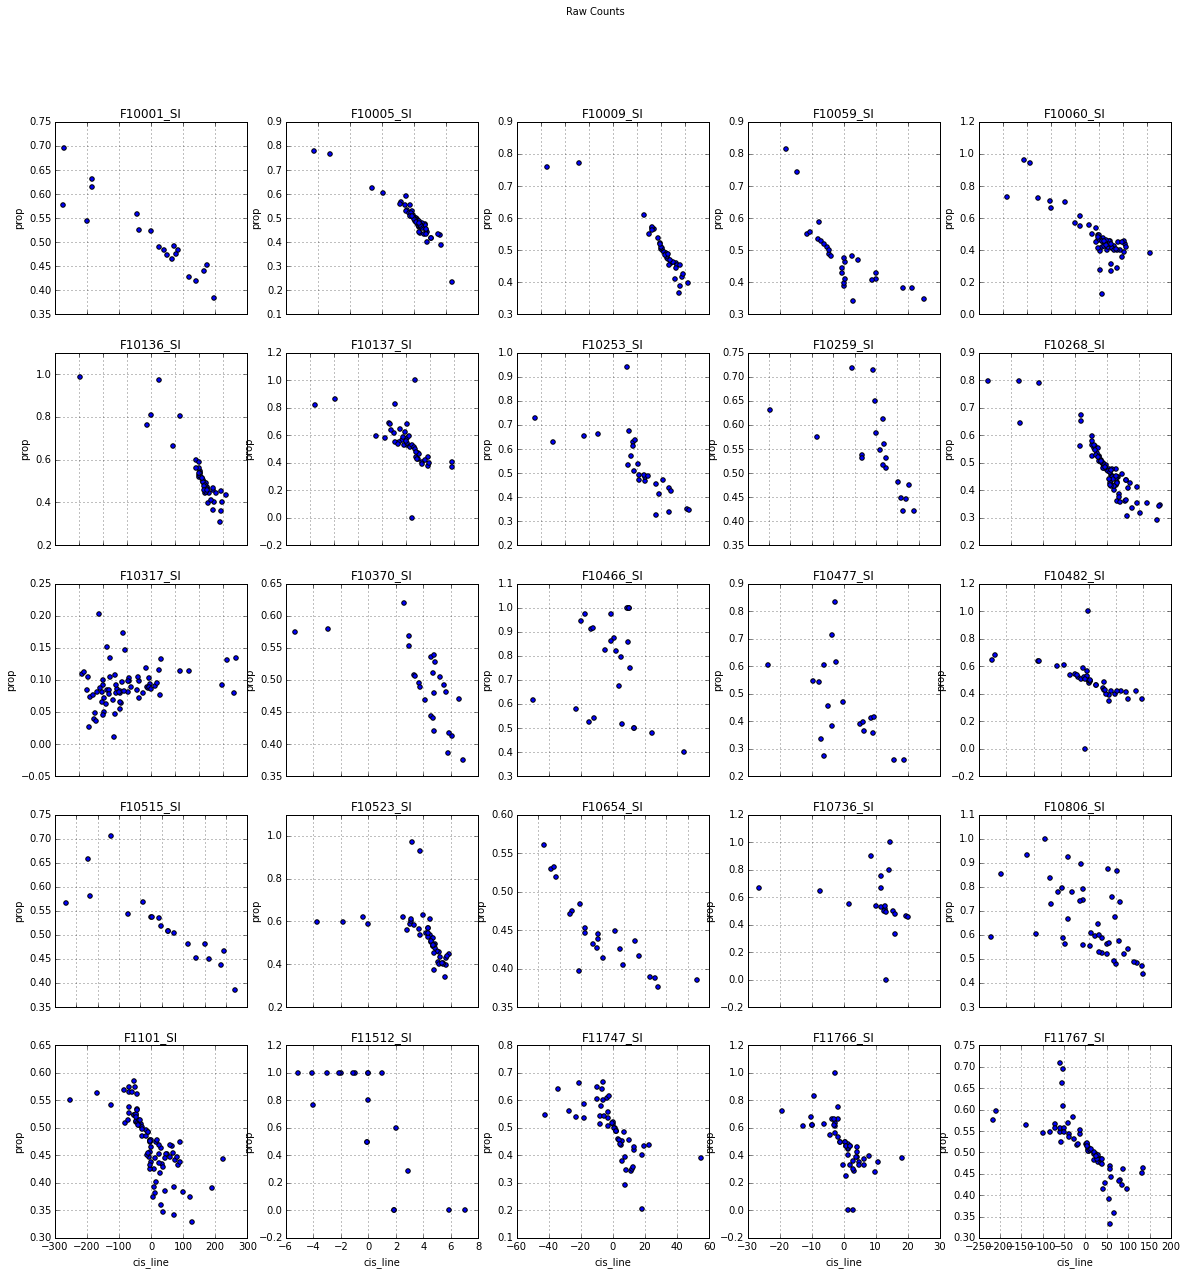

In [99]:
# Plot the cis-line effects x proportion by fusion
fig = scatPlt(marenRawCounts, line='sum_line', tester='sum_tester', title='Raw Counts')

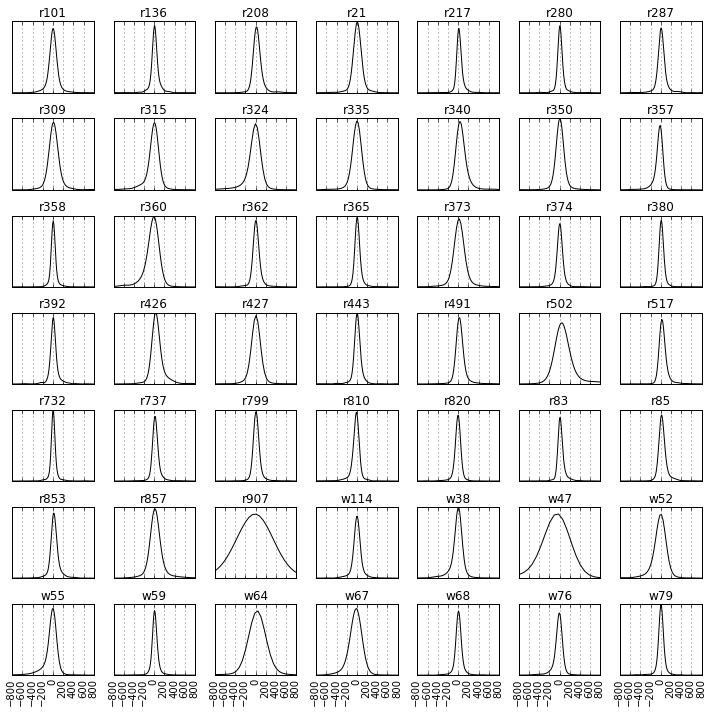

In [100]:
# Plot the distribution of cis-line effects by genotype.
fig = denPlt(marenRawCounts)

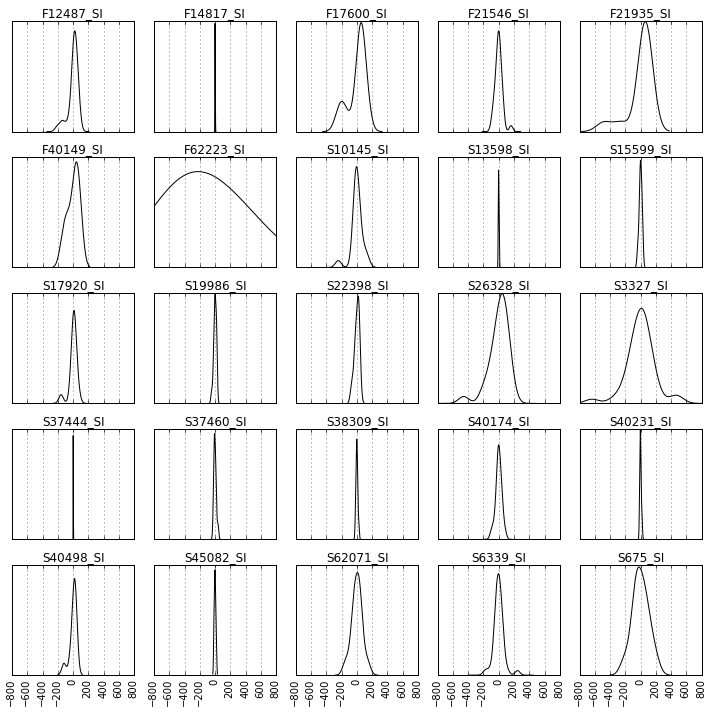

In [101]:
# Plot the distribution of cis-line effects by fusion
# Group by fusion_id
fusions = marenRawCounts.groupby('fusion_id').groups.keys()

# Get a randome set of fusions
sample = np.random.choice(fusions, size=25, replace=False)

# Plot density of 25 random fusions
fig = denPlt(marenRawCounts[marenRawCounts['fusion_id'].isin(sample)], columns='fusion_id', index='line', layout=(5, 5))
#fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/exonic_region_distributions_of_cis_line.png'))

## Coverage Centered

Center counts based on some fudge factor.

$line\_adj = \frac{sum\_line}{sum\_line + sum\_tester} * 1000$

$tester\_adj = \frac{sum\_line}{sum\_line + sum\_tester} * 1000$

In [102]:
# Center allele specific counts by taking the proportion and multiplying by 1000
dfGt10['tot_allele_specific'] = dfGt10[['sum_line', 'sum_tester']].sum(axis=1)
dfGt10['line_adj'] = dfGt10['sum_line'] / dfGt10['tot_allele_specific'] * 1000
dfGt10['tester_adj'] = dfGt10['sum_tester'] / dfGt10['tot_allele_specific'] * 1000

In [103]:
# Calculate Maren TIG equations by mating status and exonic region
marenRawCountsAdj = marenEq(dfGt10, Eii='line_adj', Eti='tester_adj', group=['mating_status', 'fusion_id'])
marenRawCountsAdj['mag_cis'] = abs(marenRawCountsAdj['cis_line'])
marenPrintTable(marenRawCountsAdj, line='line_adj', tester='tester_adj')

,,,flag_AI_combined,sum_both,line_adj,tester_adj,cis_line,cis_tester,mean_apn
line,mating_status,fusion_id,,,,,,,
r101,M,F10005_SI,0,1274,538.194444,461.805556,61.906589,-14.4823,29.523922
r280,M,F10005_SI,0,1208,468.401487,531.598513,-77.679326,-14.4823,27.917307
r315,M,F10005_SI,0,1231,520.879121,479.120879,27.275942,-14.4823,31.867690
r324,M,F10005_SI,1,2554,558.400000,441.600000,102.317700,-14.4823,60.087419
r335,M,F10005_SI,0,1339,497.685185,502.314815,-19.111930,-14.4823,33.474306
r340,M,F10005_SI,1,1897,764.976959,235.023041,515.471617,-14.4823,44.059067
r357,M,F10005_SI,1,2797,467.362924,532.637076,-79.756452,-14.4823,67.345540
r358,M,F10005_SI,0,1494,533.141210,466.858790,51.800121,-14.4823,34.797401
r365,M,F10005_SI,0,2313,499.351492,500.648508,-15.779317,-14.4823,58.291790


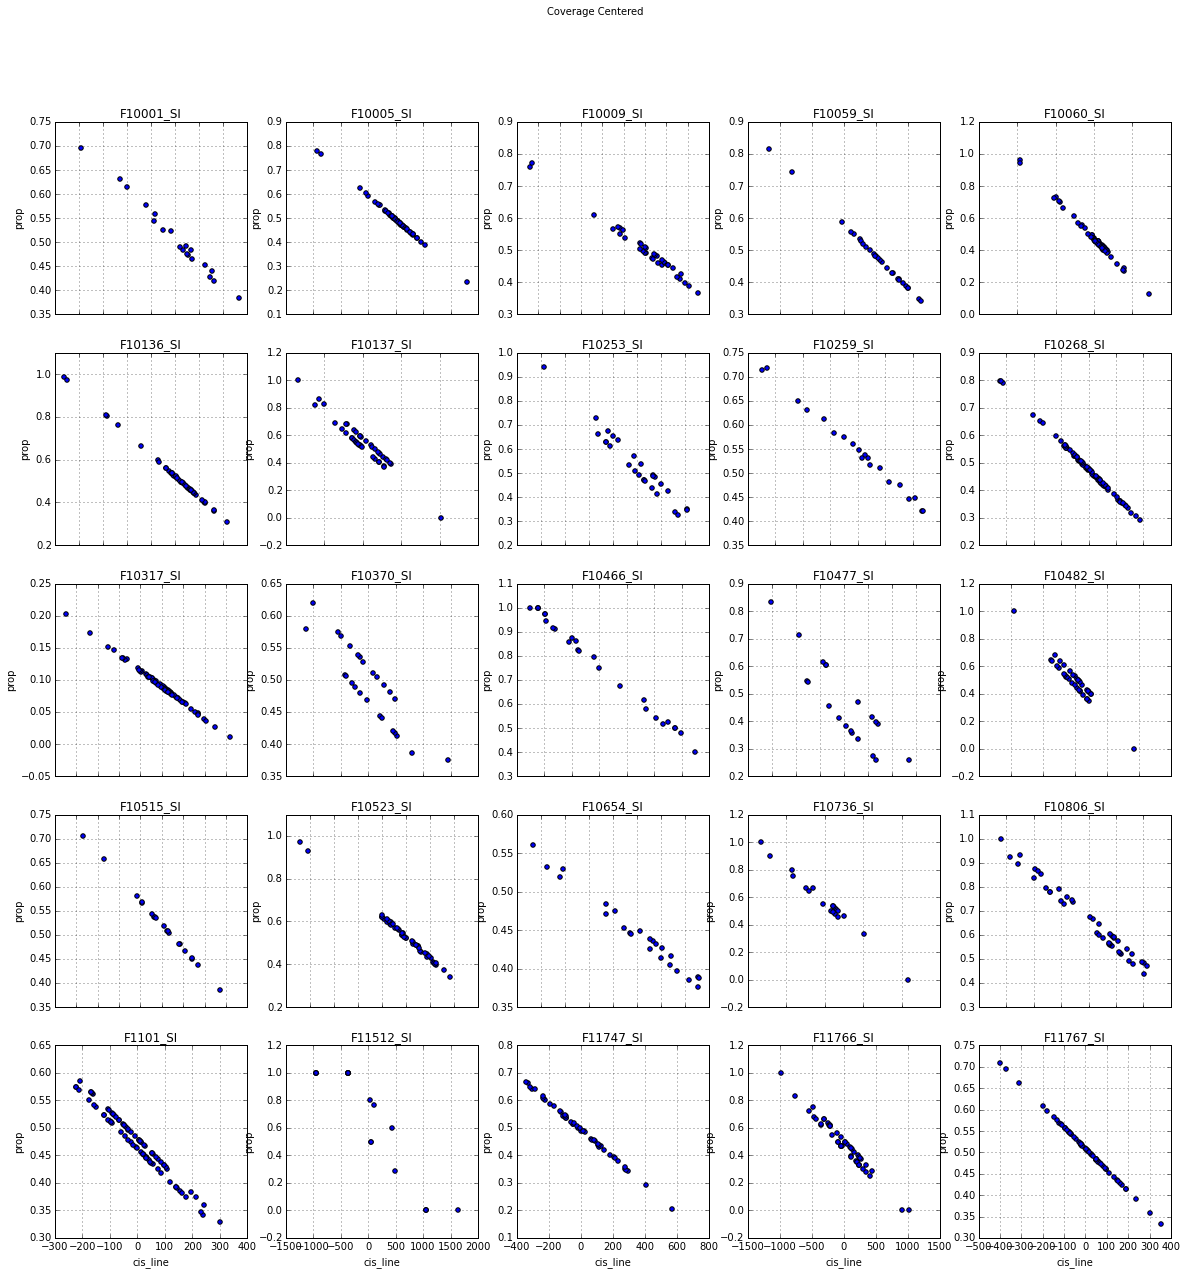

In [104]:
# Plot the cis-line effects x proportion by fusion
fig = scatPlt(marenRawCountsAdj, line='line_adj', tester='tester_adj', title='Coverage Centered')

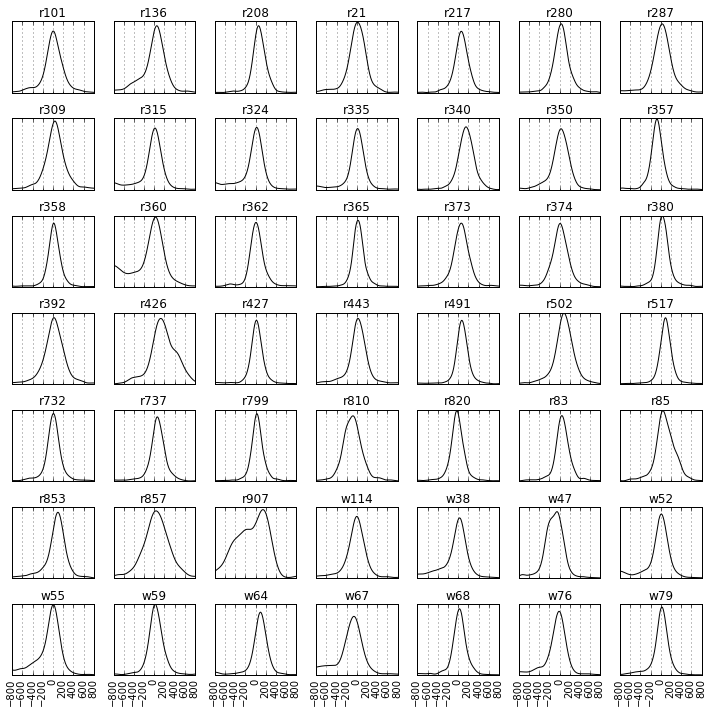

In [105]:
# Plot the distribution of cis-line effects by genotype
fig = denPlt(marenRawCountsAdj)
fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/genotype_distributions_of_cis_line.png'))

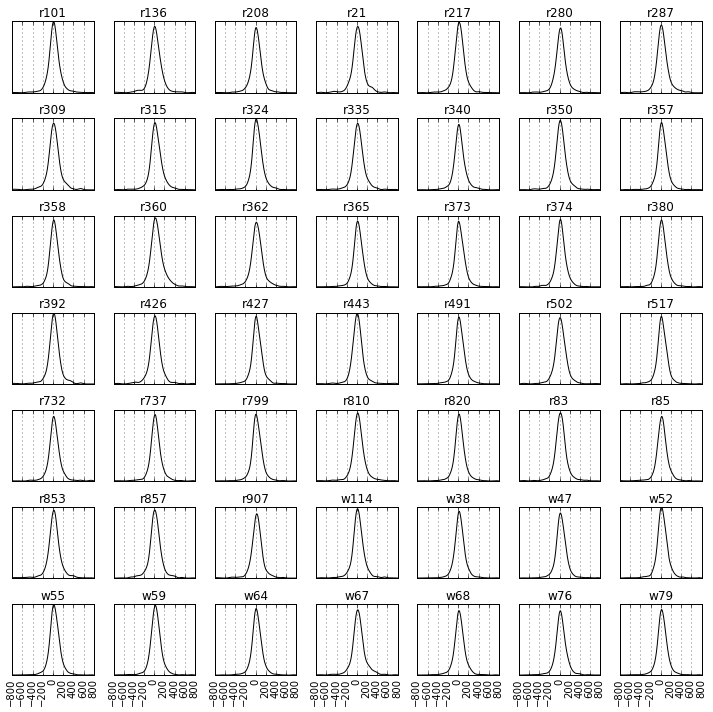

In [106]:
# Plot the distribution of cis-tester effects by genotype
fig = denPlt(marenRawCountsAdj, values='cis_tester')
fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/genotype_distributions_of_cis_tester.png'))

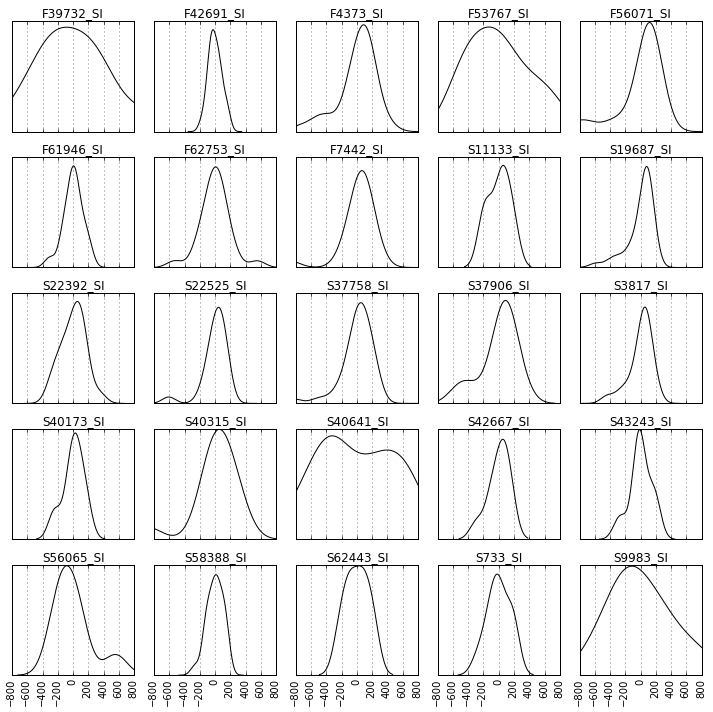

In [107]:
# Plot the distribution of cis-line effects by fusion
fusions = marenRawCountsAdj.groupby('fusion_id').groups.keys()
sample = np.random.choice(fusions, size=25, replace=False)
fig = denPlt(marenRawCountsAdj[marenRawCountsAdj['fusion_id'].isin(sample)], columns='fusion_id', index='line', layout=(5, 5))
fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/exonic_region_distributions_of_cis_line.png'))

## Mean Centered Counts
I am concerned about the calculation of $\mu$. Mean centering the raw counts will allow $\mu = 0$ and I can effectively ignore it. For each fusion_id I take the mean of all the raw counts (line and tester), then subtract this mean value from each count.

This had no affect on the results.

In [108]:
# Mean center
dfMeanCenter = meanCenter(dfGt10, columns=['sum_line', 'sum_tester'], group=['mating_status', 'fusion_id'])

In [109]:
# Calculate Maren TIG equations by mating status and exonic region for mean centered data.
marenMeanCenter = marenEq(dfMeanCenter, Eii='mean_center_sum_line', Eti='mean_center_sum_tester', group=['mating_status', 'fusion_id'])
marenMeanCenter['mag_cis'] = abs(marenMeanCenter['cis_line'])
marenPrintTable(marenMeanCenter, line='mean_center_sum_line', tester='mean_center_sum_tester')

,,,flag_AI_combined,sum_both,mean_center_sum_line,mean_center_sum_tester,cis_line,cis_tester,mean_apn
line,mating_status,fusion_id,,,,,,,
r101,M,F10005_SI,0,1274,-198.733333,-220.733333,28.666667,6.666667,29.523922
r280,M,F10005_SI,0,1208,-227.733333,-210.733333,-10.333333,6.666667,27.917307
r315,M,F10005_SI,0,1231,-116.733333,-135.733333,25.666667,6.666667,31.867690
r324,M,F10005_SI,1,2554,-4.733333,-77.733333,79.666667,6.666667,60.087419
r335,M,F10005_SI,0,1339,-138.733333,-136.733333,4.666667,6.666667,33.474306
r340,M,F10005_SI,1,1897,-21.733333,-251.733333,236.666667,6.666667,44.059067
r357,M,F10005_SI,1,2797,4.266667,54.266667,-43.333333,6.666667,67.345540
r358,M,F10005_SI,0,1494,-168.733333,-191.733333,29.666667,6.666667,34.797401
r365,M,F10005_SI,0,2313,31.266667,32.266667,5.666667,6.666667,58.291790


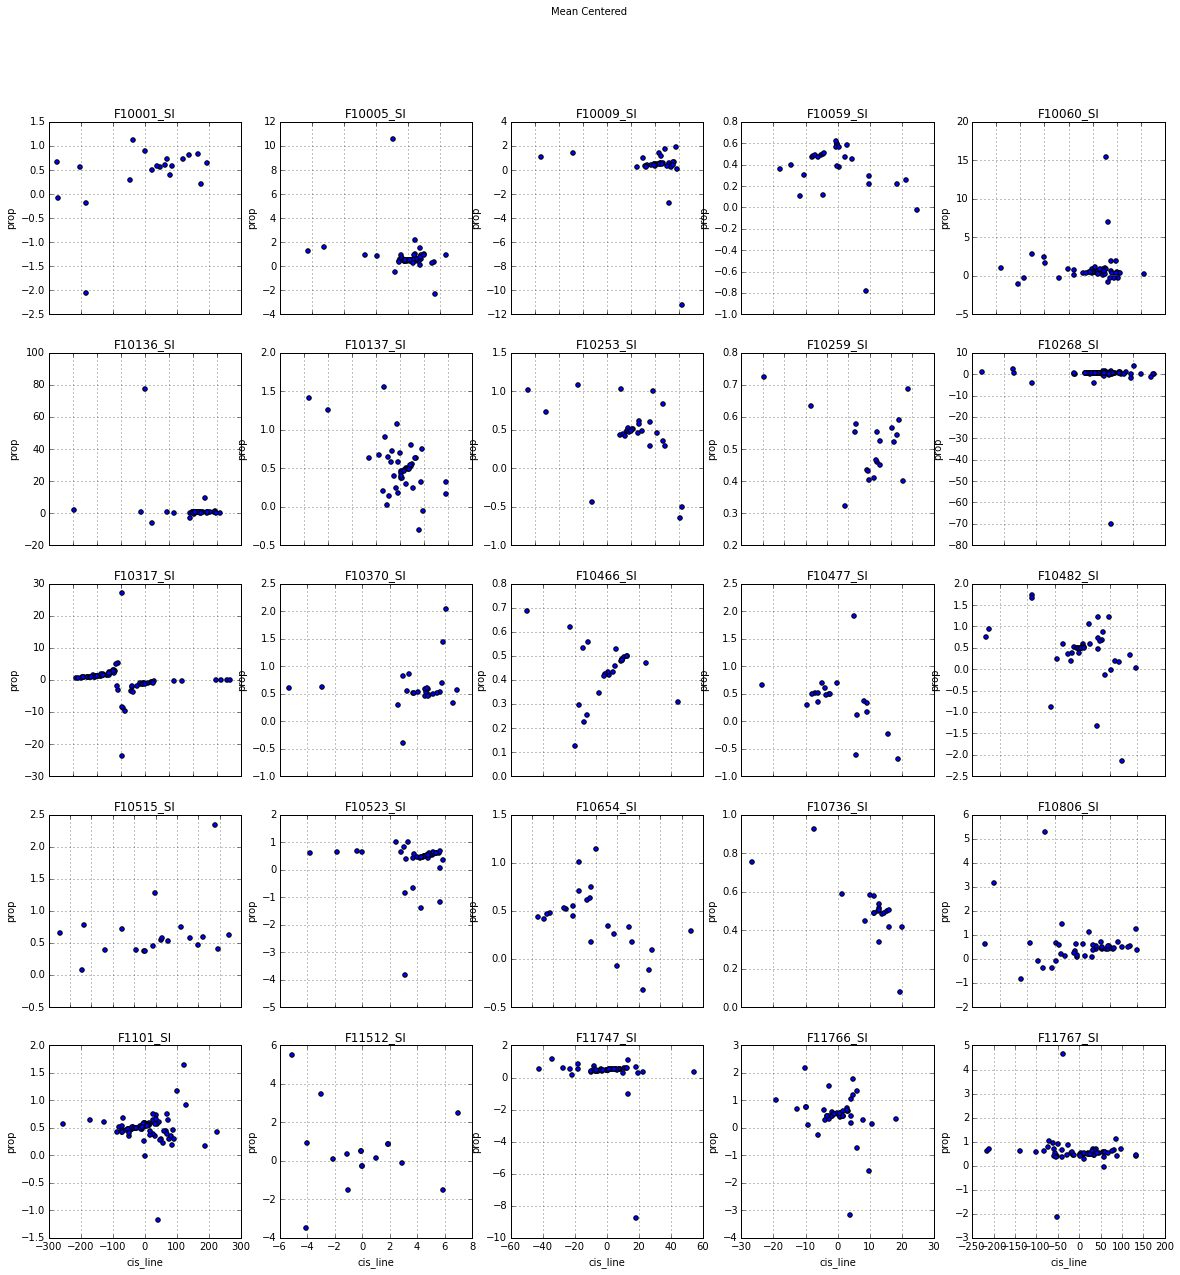

In [110]:
# Plot the cis-line effects x proportion by fusion
fig = scatPlt(marenMeanCenter, line='mean_center_sum_line', tester='mean_center_sum_tester', title='Mean Centered')

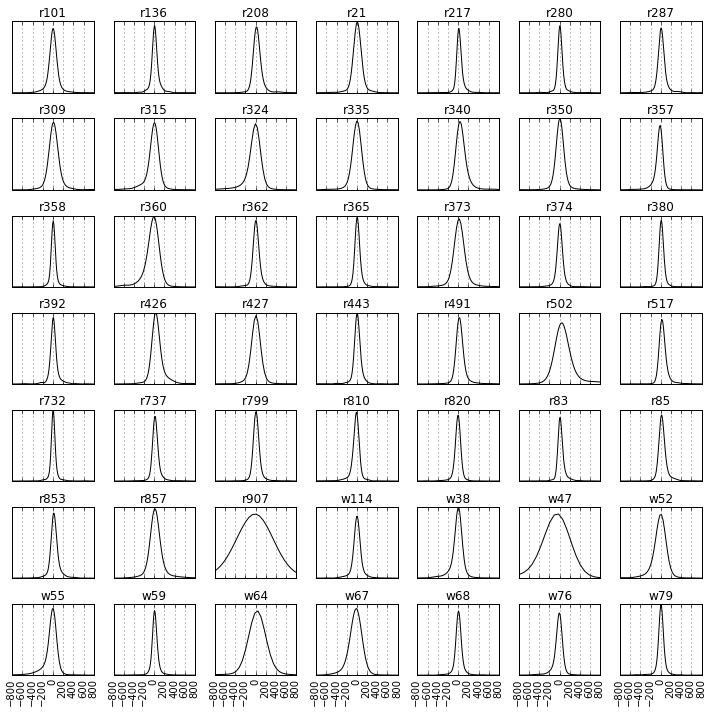

In [111]:
fig = denPlt(marenMeanCenter)

## Mean Standardized Counts

For mean standardization, for each exonic regions, I subtract the mean value of the exonic regions across genotypes and divide by the standard deviation. Note I am doing environments separately (mated and virgin).


In [112]:
# Mean standardization
dfMeanStd = dfGt10.copy()
meanStd(dfMeanStd, column='sum_line', group=['mating_status', 'fusion_id'])
meanStd(dfMeanStd, column='sum_tester', group=['mating_status', 'fusion_id'])

In [113]:
# Calculate Maren TIG equations by mating status and exonic region
marenMeanStd = marenEq(dfMeanStd, Eii='mean_std_sum_line', Eti='mean_std_sum_tester', group=['mating_status', 'fusion_id'])
marenMeanStd['mag_cis'] = abs(marenMeanStd['cis_line'])
marenPrintTable(marenMeanStd, line='mean_std_sum_line', tester='mean_std_sum_tester')

,,,flag_AI_combined,sum_both,mean_std_sum_line,mean_std_sum_tester,cis_line,cis_tester,mean_apn
line,mating_status,fusion_id,,,,,,,
r101,M,F10005_SI,0,1274,-0.799759,-0.832726,0.032966,-4.857226e-17,29.523922
r280,M,F10005_SI,0,1208,-0.918454,-0.795562,-0.122893,-4.857226e-17,27.917307
r315,M,F10005_SI,0,1231,-0.464139,-0.516830,0.052691,-4.857226e-17,31.867690
r324,M,F10005_SI,1,2554,-0.005730,-0.301278,0.295548,-4.857226e-17,60.087419
r335,M,F10005_SI,0,1339,-0.554183,-0.520546,-0.033637,-4.857226e-17,33.474306
r340,M,F10005_SI,1,1897,-0.075310,-0.947935,0.872625,-4.857226e-17,44.059067
r357,M,F10005_SI,1,2797,0.031106,0.189290,-0.158183,-4.857226e-17,67.345540
r358,M,F10005_SI,0,1494,-0.676971,-0.724950,0.047978,-4.857226e-17,34.797401
r365,M,F10005_SI,0,2313,0.141616,0.107528,0.034087,-4.857226e-17,58.291790


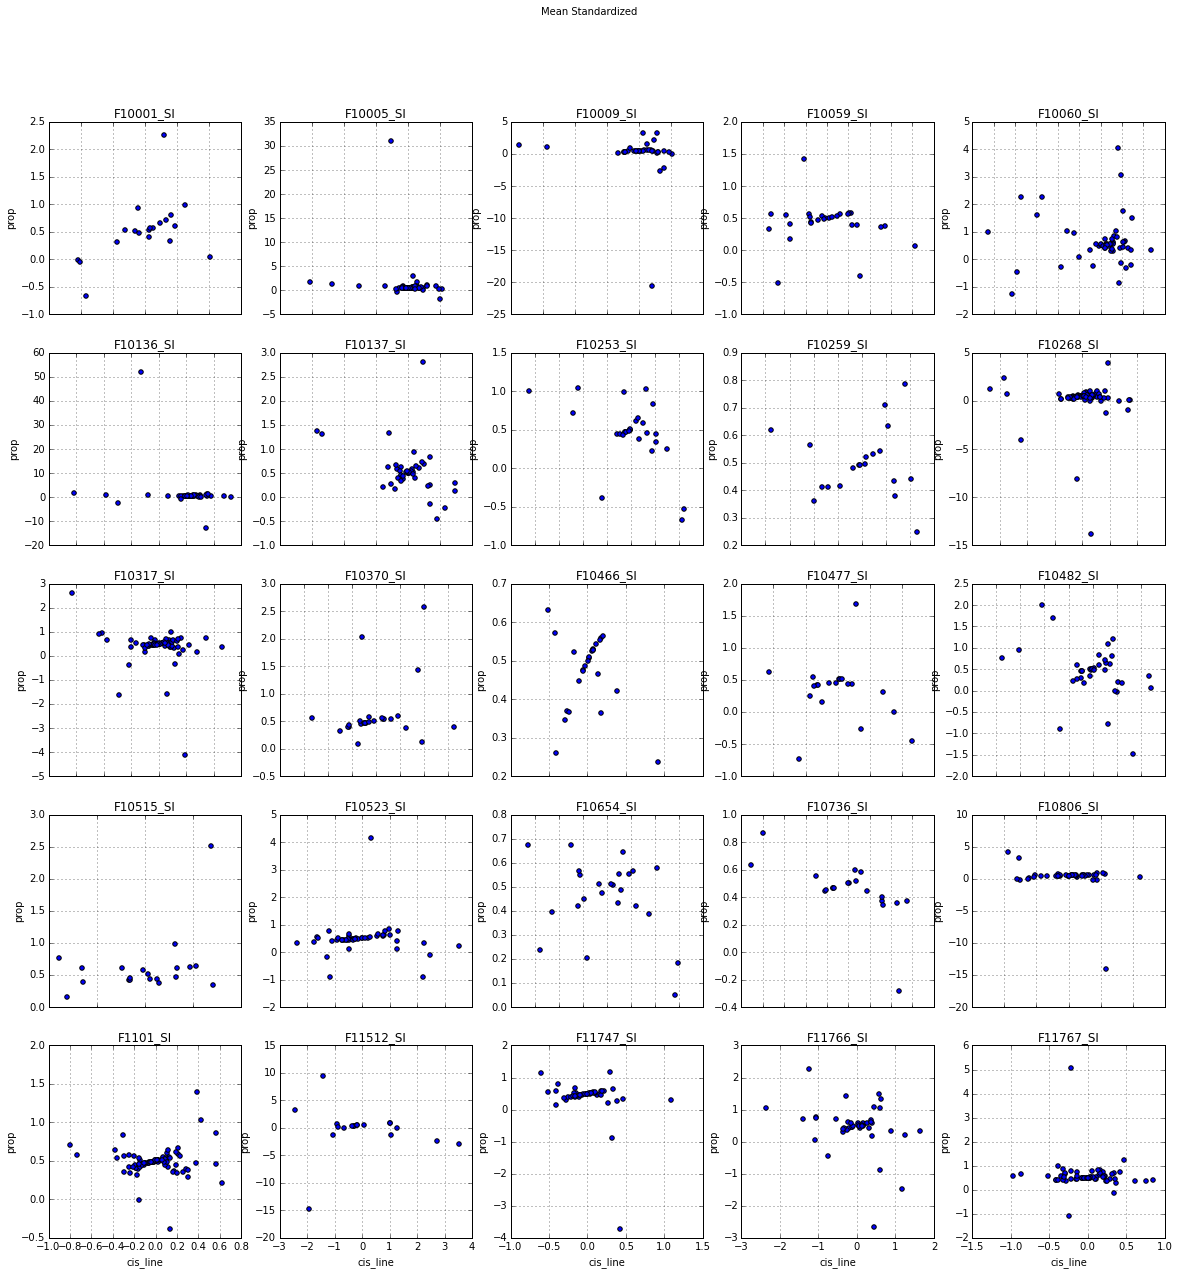

In [114]:
# Plot the cis-line effects x proportion by fusion
fig = scatPlt(marenMeanStd, line='mean_std_sum_line', tester='mean_std_sum_tester', title='Mean Standardized')

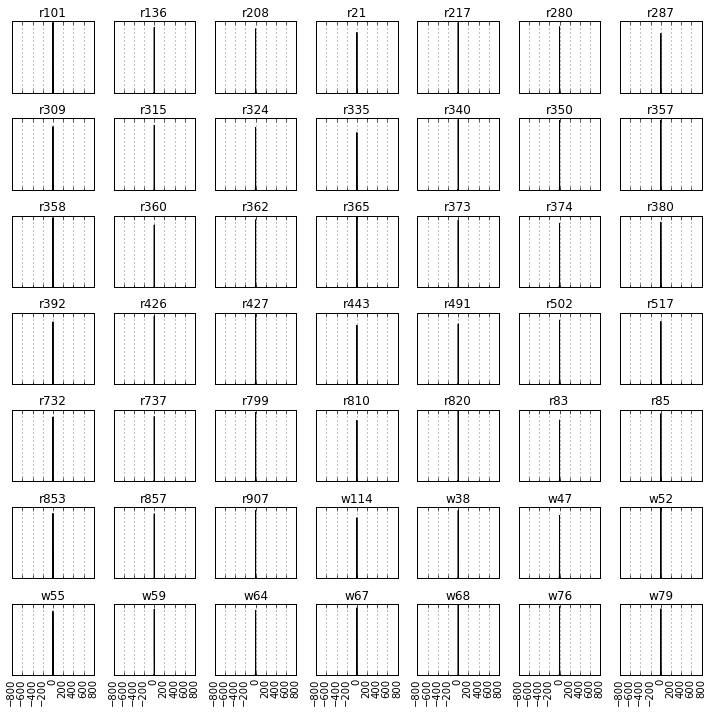

In [115]:
fig = denPlt(marenMeanStd)

## Upper Quartile Normalization

For most of the CEGS projects, we have used a q3 normalization. Here I am taking the count value / the upper quartile for the line * median of the overall upper quartile.

$\frac{\text{sum_line}_{mgf}}{q3_mg} * \widetilde {q3_m}$

Where m is the mating status ('M' or 'V'), g is genotypes 1...G and f is exonic region 1...F.

In [116]:
dfQ3 = dfGt10.set_index(['mating_status', 'line', 'fusion_id'])
dfQ3['q3_norm_sum_line'] = q3Norm(dfQ3['sum_line'])
dfQ3['q3_norm_sum_tester'] = q3Norm(dfQ3['sum_tester'])
dfQ3.reset_index(inplace=True)

In [117]:
# Calculate Maren TIG equations by mating status and exonic region
marenQ3Norm = marenEq(dfQ3, Eii='q3_norm_sum_line', Eti='q3_norm_sum_tester', group=['mating_status', 'fusion_id'])
marenQ3Norm['mag_cis'] = abs(marenQ3Norm['cis_line'])
marenPrintTable(marenQ3Norm, line='q3_norm_sum_line', tester='q3_norm_sum_tester')

,,,flag_AI_combined,sum_both,q3_norm_sum_line,q3_norm_sum_tester,cis_line,cis_tester,mean_apn
line,mating_status,fusion_id,,,,,,,
r101,M,F10005_SI,0,1274,213.641667,176.772152,22.519099,-14.350415,29.523922
r280,M,F10005_SI,0,1208,126.000000,147.749077,-36.099493,-14.350415,27.917307
r315,M,F10005_SI,0,1231,337.929310,251.538462,72.040433,-14.350415,31.867690
r324,M,F10005_SI,1,2554,309.681330,182.839117,112.491798,-14.350415,60.087419
r335,M,F10005_SI,0,1339,244.237637,221.213592,8.673630,-14.350415,33.474306
r340,M,F10005_SI,1,1897,234.670085,110.984456,109.335214,-14.350415,44.059067
r357,M,F10005_SI,1,2797,254.352234,242.891566,-2.889748,-14.350415,67.345540
r358,M,F10005_SI,0,1494,207.873641,179.052632,14.470594,-14.350415,34.797401
r365,M,F10005_SI,0,2313,261.837993,269.750416,-22.262838,-14.350415,58.291790


KeyboardInterrupt: 

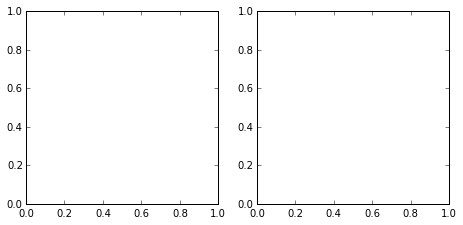

In [118]:
# Plot the cis-line effects x proportion by fusion
fig = scatPlt(marenQ3Norm, line='q3_norm_sum_line', tester='q3_norm_sum_tester', title='Q3 Normalized')

In [ ]:
fig = denPlt(marenQ3Norm)

# Plots looking at cis effects

In [208]:
fus = 'F10005_SI'
shapes = {'M': '+', 'V': '^'}

cnt = 0
colors = {}
for x in df['line']:
    colors[x]= cnt
    cnt+=1

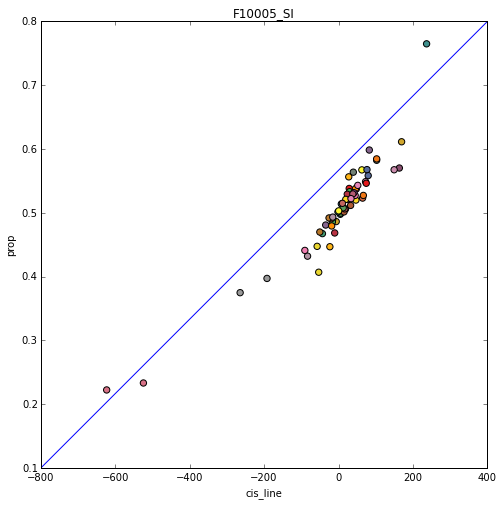

In [216]:
df = marenRawCounts[marenRawCounts['fusion_id'] == fus]

x = df['cis_line'].values
xlab = 'cis_line'

y = (1 - df['prop']).values
ylab = 'prop'

s = df['mating_status'].map(shapes)
c = df['line'].map(colors)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(x=x, y=y, s=40, c=c, cmap='Set1')
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.set_title(fus)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)

In [206]:
df['trans_tester1'] = df['sum_line'].sum() / df.shape[0]
df['trans_tester2'] = df['sum_tester'].sum() / df.shape[0] - df['cis_tester']
df

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,line,mating_status,fusion_id,flag_AI_combined,q5_mean_theta,sum_both,sum_line,sum_tester,sum_total,mean_apn,cis_line,cis_tester,mag_cis,prop,trans_tester1,trans_tester2,trans_line1,trans_line2
10,r101,M,F10005_SI,0,0.475,1274,155,133,1562,29.523922,28.666667,6.666667,28.666667,0.461806,361.25,356.633333,-234.916667,-234.916667
11,r280,M,F10005_SI,0,0.545,1208,126,143,1477,27.917307,-10.333333,6.666667,10.333333,0.531599,361.25,356.633333,-224.916667,-224.916667
12,r315,M,F10005_SI,0,0.490,1231,237,218,1686,31.867690,25.666667,6.666667,25.666667,0.479121,361.25,356.633333,-149.916667,-149.916667
13,r324,M,F10005_SI,1,0.450,2554,349,276,3179,60.087419,79.666667,6.666667,79.666667,0.441600,361.25,356.633333,-91.916667,-91.916667
14,r335,M,F10005_SI,0,0.514,1339,215,217,1771,33.474306,4.666667,6.666667,4.666667,0.502315,361.25,356.633333,-150.916667,-150.916667
15,r340,M,F10005_SI,1,0.241,1897,332,102,2331,44.059067,236.666667,6.666667,236.666667,0.235023,361.25,356.633333,-265.916667,-265.916667
16,r357,M,F10005_SI,1,0.542,2797,358,408,3563,67.345540,-43.333333,6.666667,43.333333,0.532637,361.25,356.633333,40.083333,40.083333
17,r358,M,F10005_SI,0,0.480,1494,185,162,1841,34.797401,29.666667,6.666667,29.666667,0.466859,361.25,356.633333,-205.916667,-205.916667
18,r365,M,F10005_SI,0,0.508,2313,385,386,3084,58.291790,5.666667,6.666667,5.666667,0.500649,361.25,356.633333,18.083333,18.083333
19,r373,M,F10005_SI,0,0.450,1546,146,113,1805,34.116952,39.666667,6.666667,39.666667,0.436293,361.25,356.633333,-254.916667,-254.916667


In [207]:
df['trans_line1'] = df['sum_line'] - df['cis_line'] - df['trans_tester1']
df['trans_line2'] = df['sum_tester'] - df['cis_tester'] - df['trans_tester1']

df['trans_line3'] = 2 * (df['sum_tester'] - df['cis_tester'] - df['trans_tester1'] / 2)
df

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentatio

,line,mating_status,fusion_id,flag_AI_combined,q5_mean_theta,sum_both,sum_line,sum_tester,sum_total,mean_apn,cis_line,cis_tester,mag_cis,prop,trans_tester1,trans_tester2,trans_line1,trans_line2,trans_line3
10,r101,M,F10005_SI,0,0.475,1274,155,133,1562,29.523922,28.666667,6.666667,28.666667,0.461806,361.25,356.633333,-234.916667,-234.916667,-108.583333
11,r280,M,F10005_SI,0,0.545,1208,126,143,1477,27.917307,-10.333333,6.666667,10.333333,0.531599,361.25,356.633333,-224.916667,-224.916667,-88.583333
12,r315,M,F10005_SI,0,0.490,1231,237,218,1686,31.867690,25.666667,6.666667,25.666667,0.479121,361.25,356.633333,-149.916667,-149.916667,61.416667
13,r324,M,F10005_SI,1,0.450,2554,349,276,3179,60.087419,79.666667,6.666667,79.666667,0.441600,361.25,356.633333,-91.916667,-91.916667,177.416667
14,r335,M,F10005_SI,0,0.514,1339,215,217,1771,33.474306,4.666667,6.666667,4.666667,0.502315,361.25,356.633333,-150.916667,-150.916667,59.416667
15,r340,M,F10005_SI,1,0.241,1897,332,102,2331,44.059067,236.666667,6.666667,236.666667,0.235023,361.25,356.633333,-265.916667,-265.916667,-170.583333
16,r357,M,F10005_SI,1,0.542,2797,358,408,3563,67.345540,-43.333333,6.666667,43.333333,0.532637,361.25,356.633333,40.083333,40.083333,441.416667
17,r358,M,F10005_SI,0,0.480,1494,185,162,1841,34.797401,29.666667,6.666667,29.666667,0.466859,361.25,356.633333,-205.916667,-205.916667,-50.583333
18,r365,M,F10005_SI,0,0.508,2313,385,386,3084,58.291790,5.666667,6.666667,5.666667,0.500649,361.25,356.633333,18.083333,18.083333,397.416667
19,r373,M,F10005_SI,0,0.450,1546,146,113,1805,34.116952,39.666667,6.666667,39.666667,0.436293,361.25,356.633333,-254.916667,-254.916667,-148.583333
